In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models, optimizers
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import os
import time
import tarfile
import pickle

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [15]:
# If you're loading CIFAR-10 from a tar file
def load_pickle_from_tar(tar_path, pickle_path):
    with tarfile.open(tar_path, 'r') as tar:
        member = tar.getmember(pickle_path)
        f = tar.extractfile(member)
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict

# Set your tar_path to the file in the same working folder
tar_path = "cifar-10-python.tar"  # File in the same working directory

# Load training data
train_data = []
train_labels = []

print("Loading training data...")
# The path structure below is based on the standard CIFAR-10 distribution
for i in range(1, 6):
    batch_path = f'cifar-10-batches-py/data_batch_{i}'
    print(f"Loading batch {i}...")
    batch_dict = load_pickle_from_tar(tar_path, batch_path)
    train_data.append(batch_dict[b'data'])
    train_labels.extend(batch_dict[b'labels'])

train_data = np.vstack(train_data)

Loading training data...
Loading batch 1...
Loading batch 2...
Loading batch 3...
Loading batch 4...
Loading batch 5...


In [16]:
print("Loading test data...")
test_batch_path = 'cifar-10-batches-py/test_batch'
test_dict = load_pickle_from_tar(tar_path, test_batch_path)
test_data = test_dict[b'data']
test_labels = test_dict[b'labels']

# Load label names
print("Loading label names...")
meta_path = 'cifar-10-batches-py/batches.meta'
meta_dict = load_pickle_from_tar(tar_path, meta_path)
label_names = [label.decode('utf-8') for label in meta_dict[b'label_names']]

# Print basic info about the data
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Label names: {label_names}")


Loading test data...
Loading label names...
Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
# Reshape the data to match the expected input format for CNN
# Each image is 32x32 pixels with 3 color channels (RGB)
X_train = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, 32, 32, 3)
X_test = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, 32, 32, 3)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Print updated shapes
print("Training data shape after reshaping:", X_train.shape)
print("Test data shape after reshaping:", X_test.shape)


Training data shape after reshaping: (50000, 32, 32, 3)
Test data shape after reshaping: (10000, 32, 32, 3)


In [18]:
# Preprocess the data
def preprocess_data(X_train, y_train, X_test, y_test):
    # Normalize pixel values to be between 0 and 1
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Convert class vectors to binary class matrices (one-hot encoding)
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    # Create a validation set (10% of training data)
    val_size = int(0.1 * X_train.shape[0])
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train = X_train[:-val_size]
    y_train = y_train[:-val_size]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Apply preprocessing
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

# Print updated shapes
print("Training data shape after preprocessing:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape after preprocessing: (45000, 32, 32, 3)
Validation data shape: (5000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


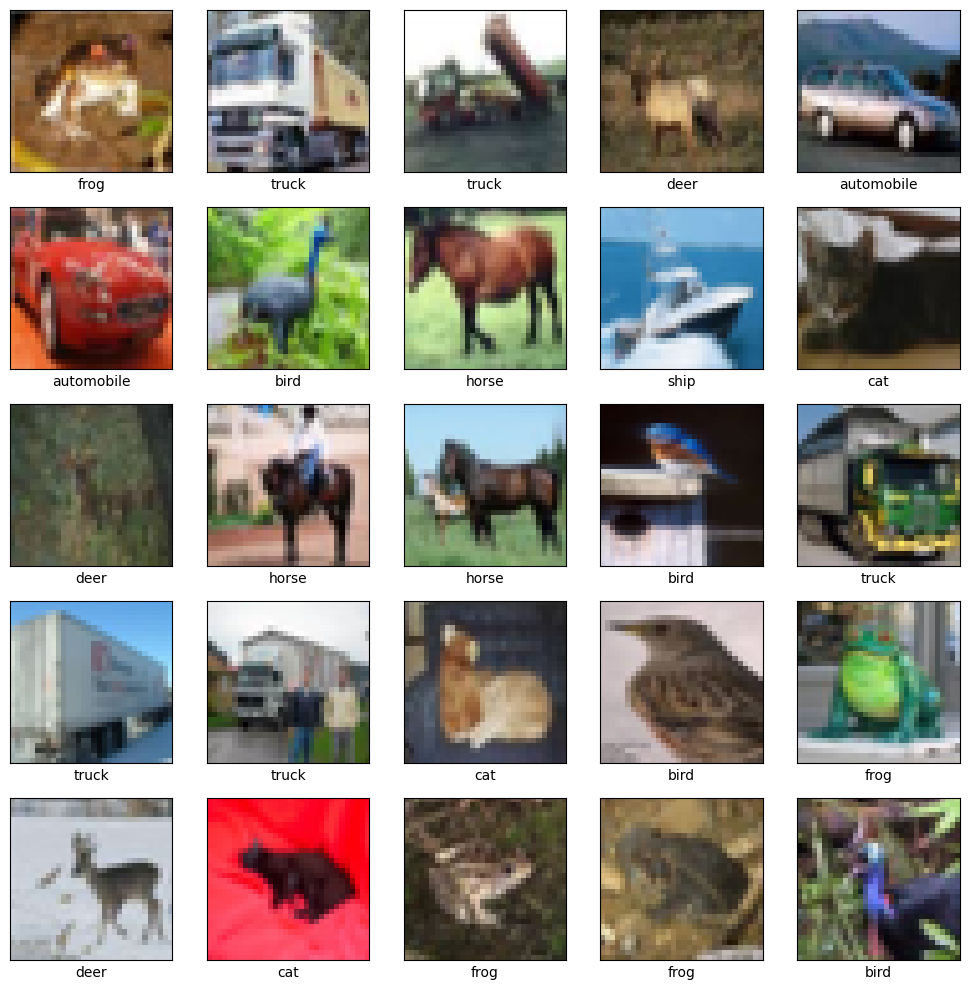

In [19]:
# Visualize some sample images to verify correct reshaping
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(label_names[np.argmax(y_train[i])])
plt.tight_layout()
plt.show()


In [20]:
# Define the CNN model architecture
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Create and compile the model
model = create_cnn_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [22]:
# Define callbacks for early stopping and model checkpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', 
                    save_best_only=True, mode='max')
]

# Train the model
start_time = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/50
258/704 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.2933 - loss: 2.4474

KeyboardInterrupt: 